<a href="https://colab.research.google.com/github/rocodoco20/AI1week/blob/main/AI_Agent_example_with_Weave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />
<!--- @wandbcode{intro-colab} -->

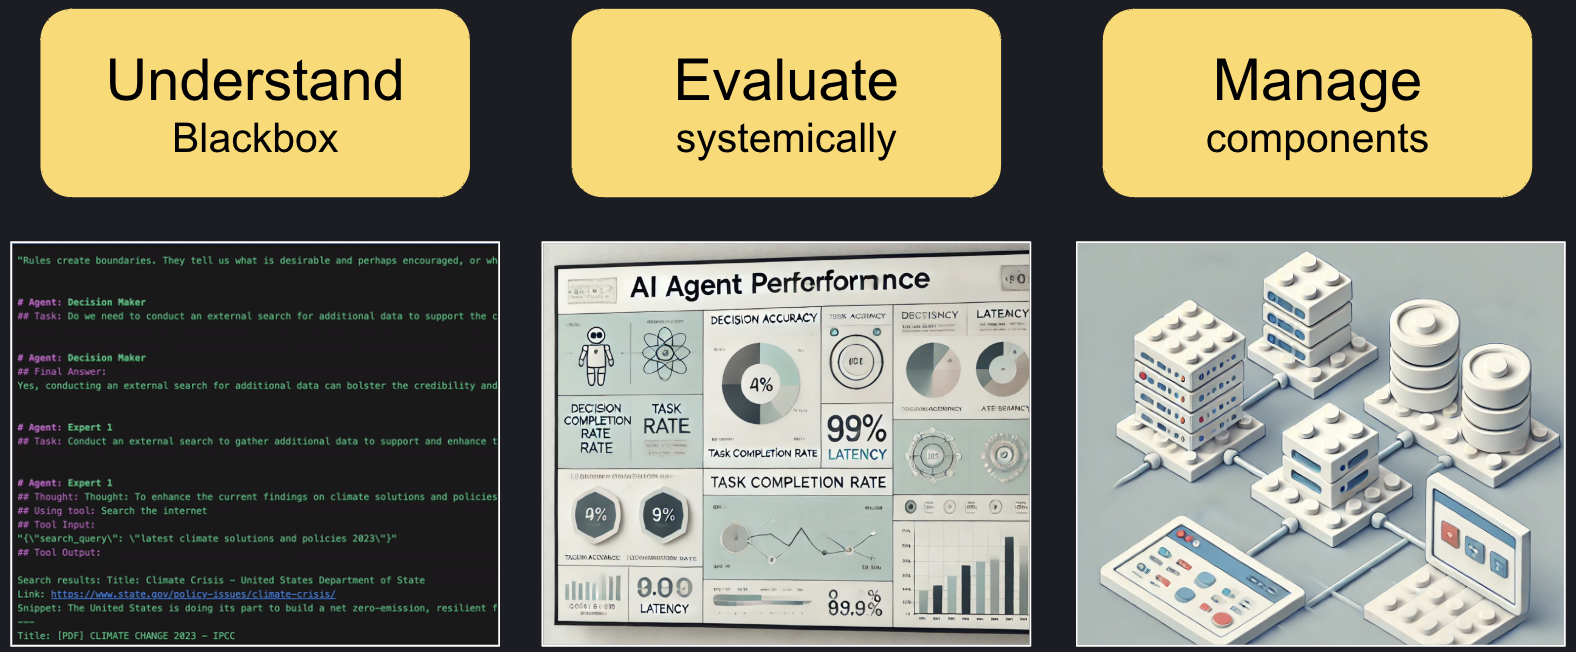

[W&B Weave](https://wandb.ai) 를 이용하여 GenAI 어플리케이션의 입출력과 체계적인 평가, 구성요소의 관리를 수행할 수 있습니다.

- [Weave 도큐멘테이션](https://weave-docs.wandb.ai/)
- [Weave Cookbook](https://weave-docs.wandb.ai/reference/gen_notebooks/intro_notebook/)
- [W&B 에서 운영하는 강의 플랫폼](https://www.wandb.courses/pages/w-b-courses)
- [LLM Engineering: Structured output 코스](https://www.wandb.courses/courses/steering-language-models)
- [W&B Models를 이용한 LLM Training & Fine-tuning 유튜브 코스](https://www.youtube.com/playlist?list=PLD80i8An1OEGqqXeNZ5w0IBmeZcxpZEYL)

이 노트북은 Tool-use 유무에 따른 AI Agent의 논리흐름을 가시화하는 작업이 담겨있습니다. crewai를 이용하여 간단한 AI Agent를 개발하고, Weave를 통해 모든 입출력을 확인하며, 평가를 통해 성능의 차이를 확인할 수 있습니다.

궁금한 점이 있으시면 편하게 연락주세요!
- SNS: [linkedin](https://www.linkedin.com/in/hyunwoo-oh-461462153/)
- W&B 문의 메일: contact-kr@wandb.com

In [ ]:
  !pip install -q -U weave
  !pip install -q -U crewai
  !pip install -q -U crewai[tools]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.2/368.2 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.8/325.8 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 59.6 MB/s

In [ ]:
from crewai import Agent, Task, Crew, Process
from crewai_tools import SerperDevTool, DirectorySearchTool
from typing import List, Dict
import weave
import os
import time
import io
from contextlib import redirect_stdout
import yaml

In [ ]:
OPENAI_API_KEY = '' # @param {type:"string"}
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [ ]:
SERPER_API_KEY = '' # @param {type:"string"}
os.environ["SERPER_API_KEY"] = SERPER_API_KEY

In [ ]:
# Weave project 생성
weave.init("ai-agent-search-example")

Please login to Weights & Biases (https://wandb.ai/) to continue:


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Logged in as Weights & Biases user: rocodoco20.
View Weave data at https://wandb.ai/rocodoco20-colaborandonet/ai-agent-search-example/weave


# 에이전트 개발
crewai를 이용하여 검색 기능 유무에 따른 챗봇의 결과를 비교합니다.

Weave를 이용하여 챗봇 코드의 버전관리를 수행합니다.

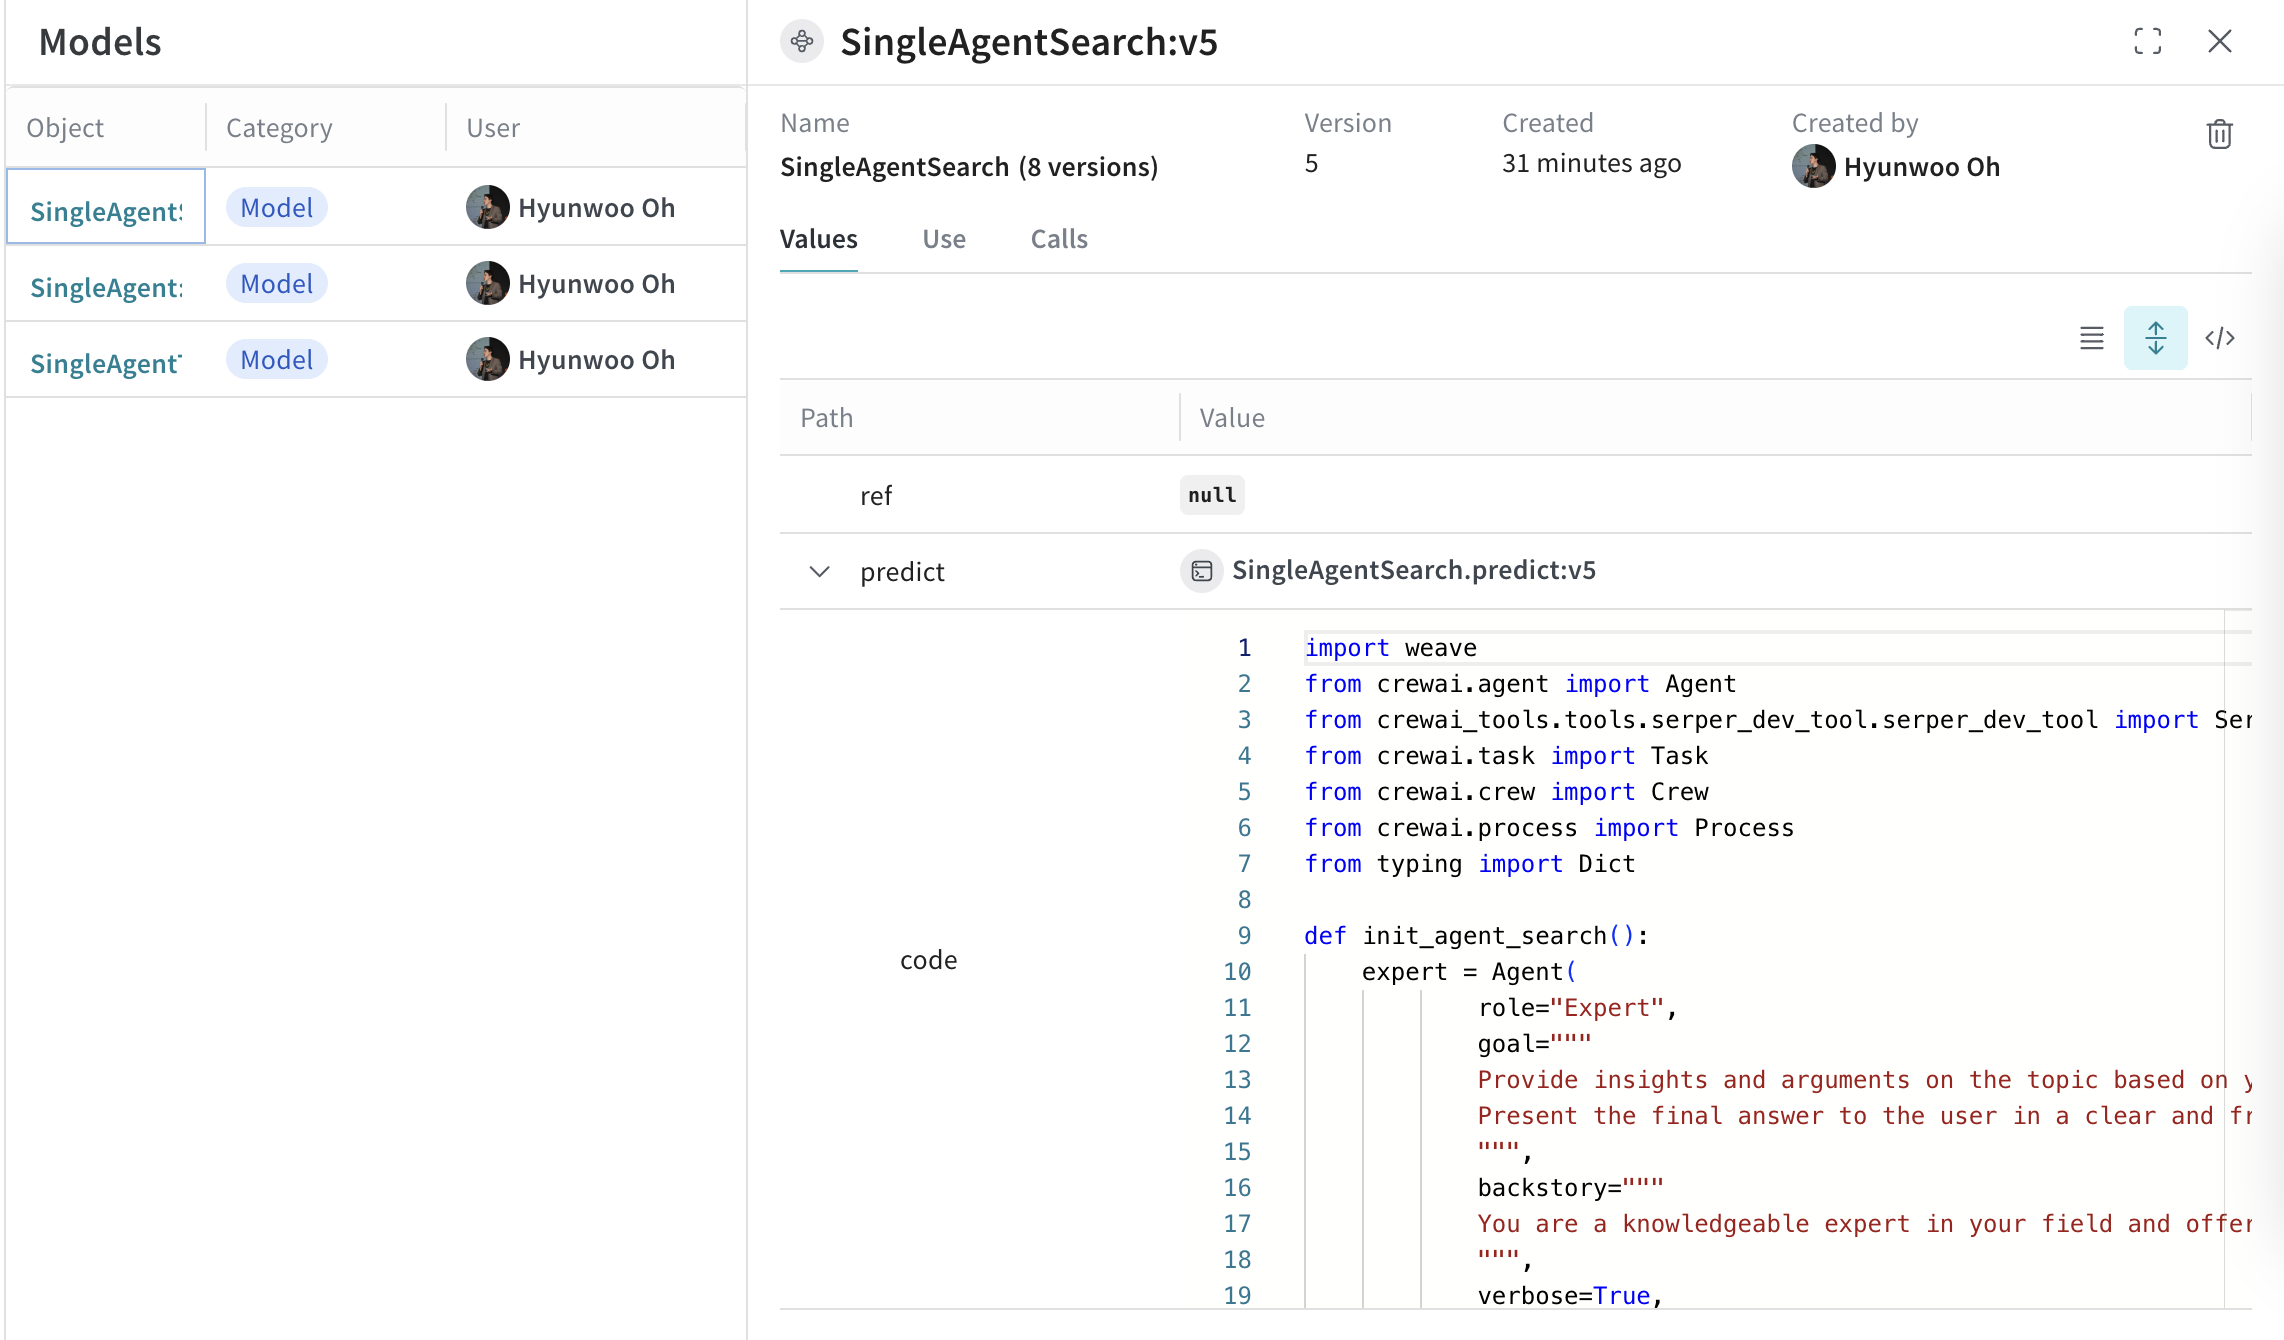

call의 모든 Trace(입출력)을 기록하여 가시성을 확보합니다.

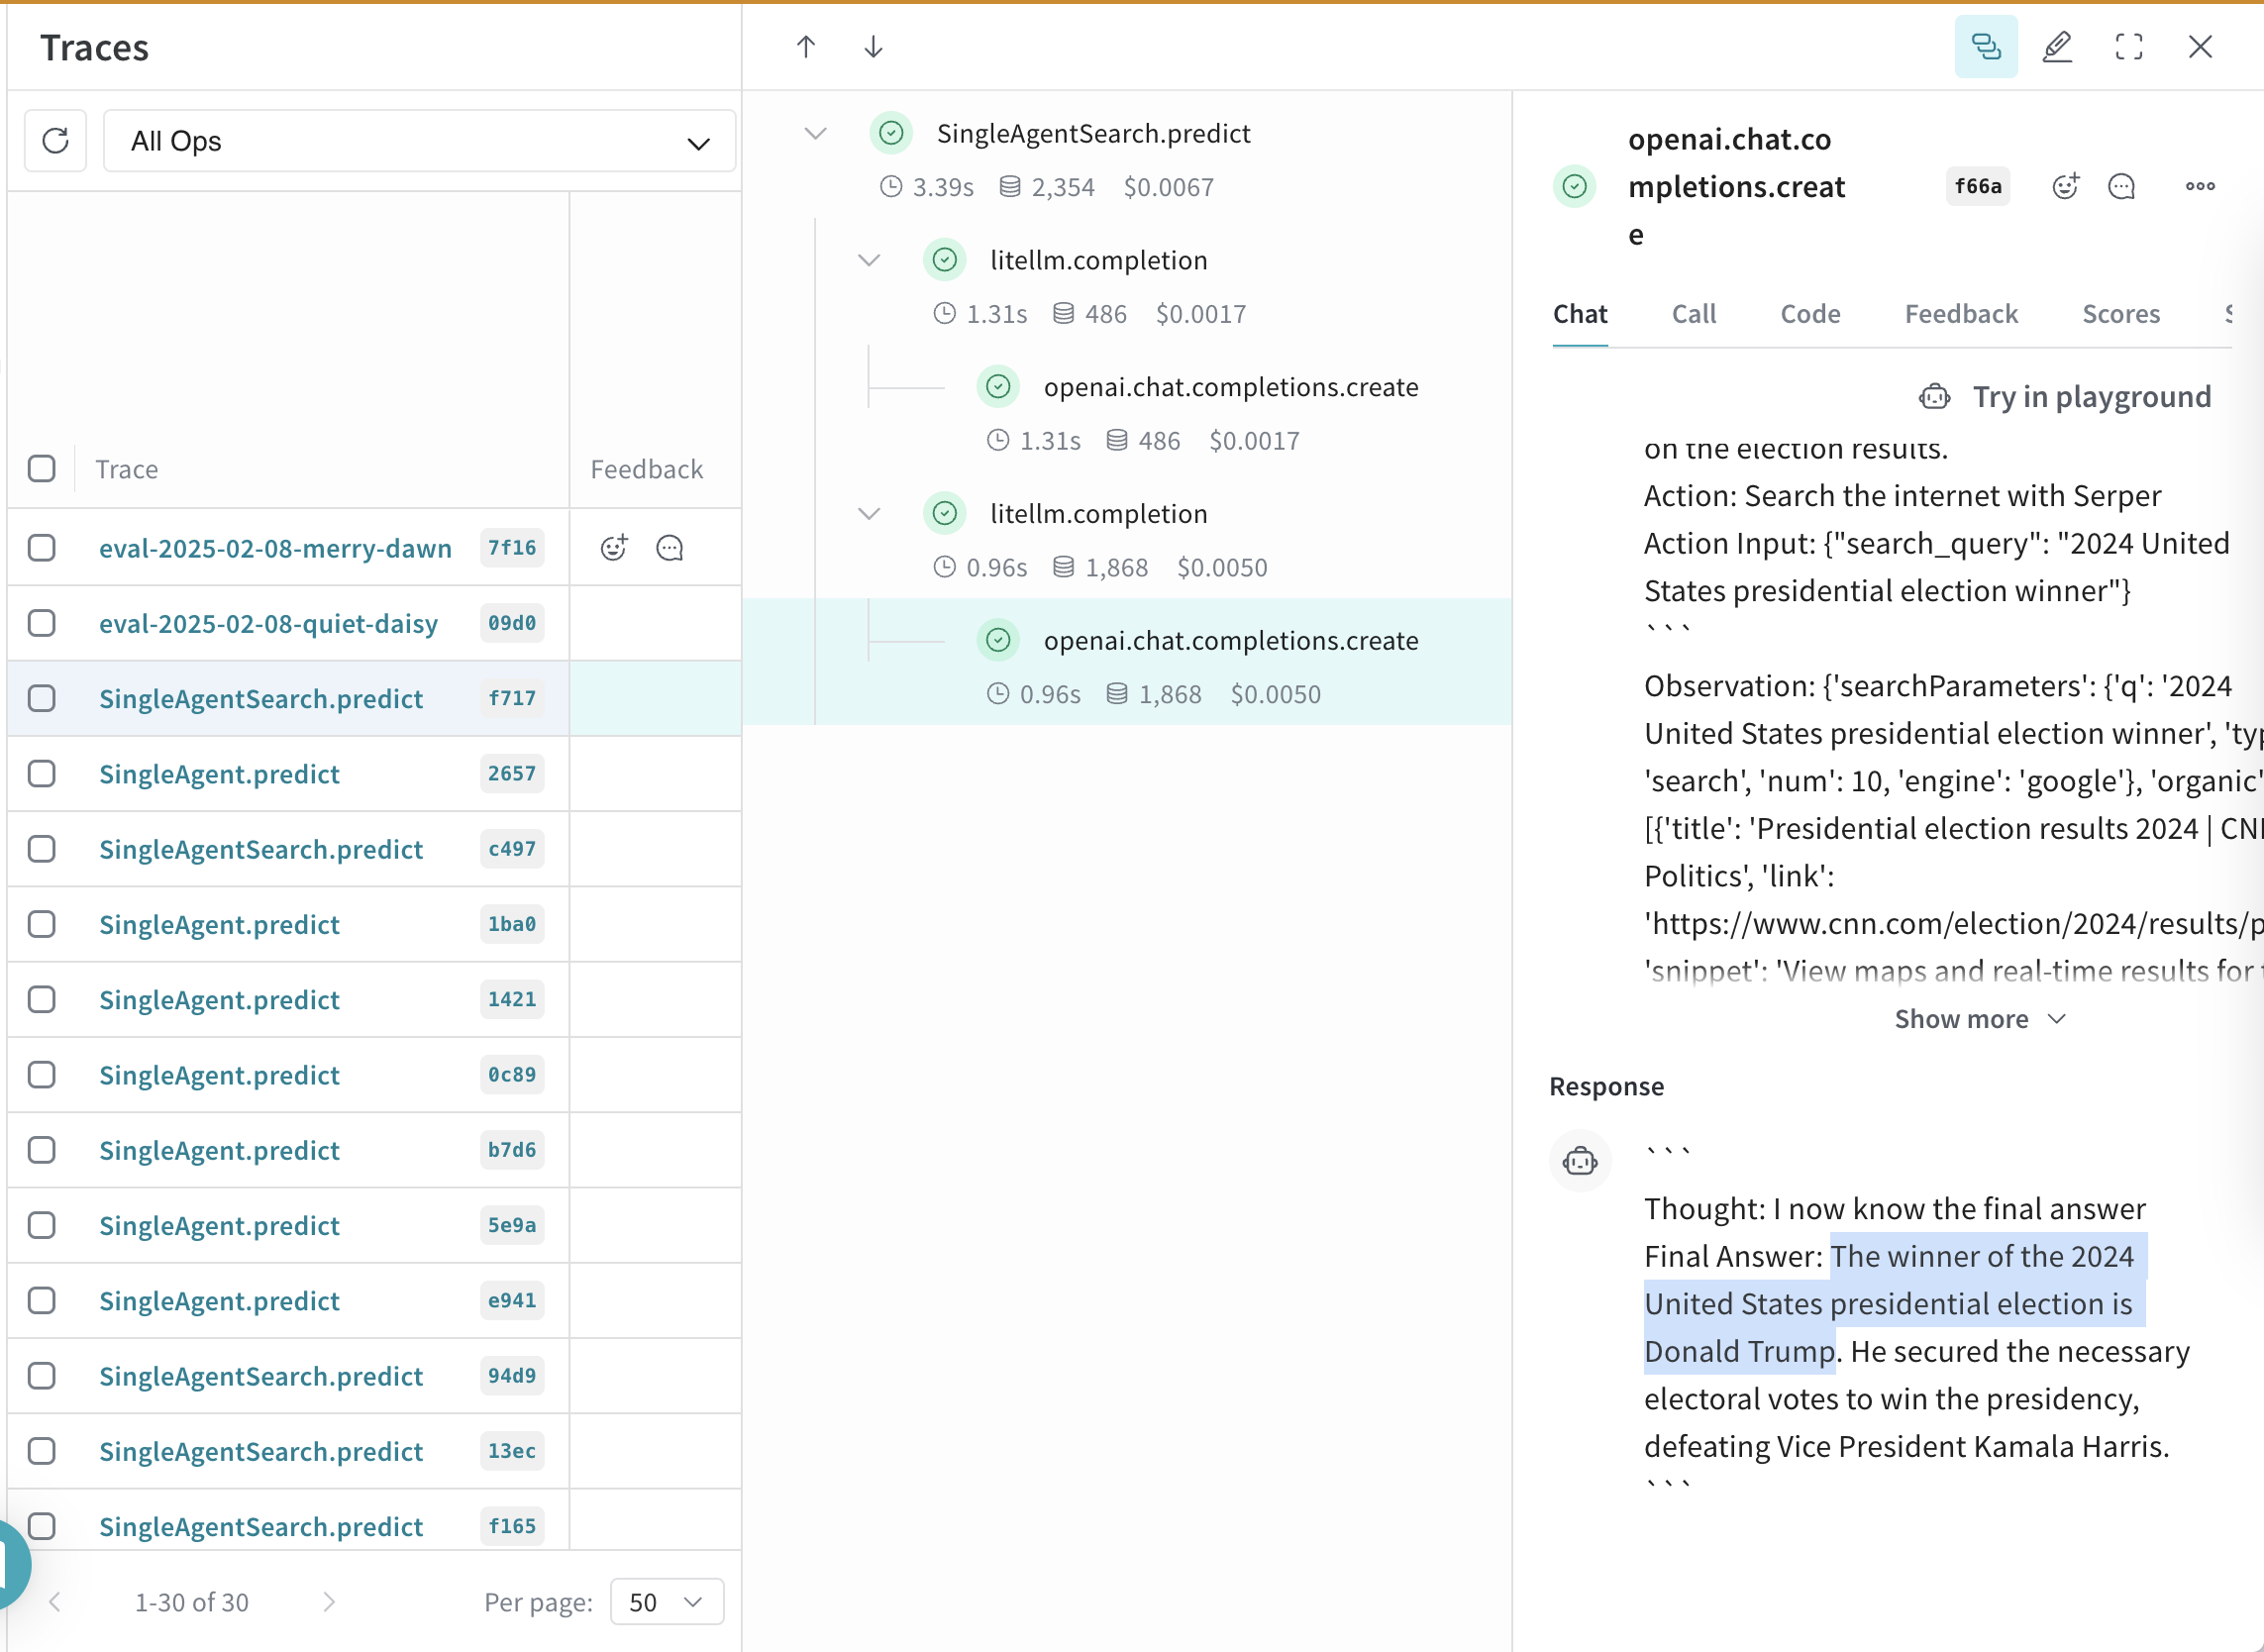

In [ ]:
# gpt-4o-2024-08-06 chatbot 생성
def init_agent():
    expert = Agent(
            role="Expert",
            goal="""
            Provide insights and arguments on the topic based on your expertise.
            Present the final answer to the user in a clear and friendly manner. Please provide a concise answer in no more than 50 words.
            """,
            backstory="""
            You are a knowledgeable expert in your field and offer unique perspectives and in-depth analysis on the topic in question.
            """,
            verbose=True,
            llm="openai/gpt-4o-2024-08-06",
            )
    expert_discussion = Task(
        description="""
        Expert provides insights based on the knowledge of expertise on the {topic}.
        This includes presenting initial thoughts and arguments.
        """,
        expected_output="""Insights and arguments from Expert regarding the {topic}""",
        agent=expert,
        verbose=True
    )
    return [expert], [expert_discussion]

class SingleAgent(weave.Model): # 버전 관리를 위해 weave.Model 상속
    @weave.op() # Trace 기록을 위해 @weave.op() 사용
    def predict(self, Question) -> Dict:
        inputs = {
            'topic': Question
        }
        agents, tasks = init_agent()
        crew = Crew(
            agents=agents,
            tasks=tasks,
            verbose=True,
            process=Process.sequential,
            full_output=False,
        )
        result = crew.kickoff(inputs=inputs)
        output = {
            "question":Question,
            "result":result.raw
            }
        return output

In [ ]:
# gpt-4o-2024-08-06 + search chatbot 생성
def init_agent_search():
    expert = Agent(
            role="Expert",
            goal="""
            Provide insights and arguments on the topic based on your expertise.
            Present the final answer to the user in a clear and friendly manner. Please provide a concise answer in no more than 50 words.
            """,
            backstory="""
            You are a knowledgeable expert in your field and offer unique perspectives and in-depth analysis on the topic in question.
            """,
            verbose=True,
            llm="openai/gpt-4o-2024-08-06",
            tools=[SerperDevTool()]
            )
    expert_discussion = Task(
        description="""
        Expert provides insights based on the knowledge of expertise on the {topic}.
        This includes presenting initial thoughts and arguments.
        """,
        expected_output="""Insights and arguments from Expert regarding the {topic}""",
        agent=expert,
        verbose=True
    )
    return [expert], [expert_discussion]

class SingleAgentSearch(weave.Model):
    @weave.op()
    def predict(self, Question) -> Dict:
        inputs = {
            'topic': Question
        }
        agents, tasks = init_agent_search()
        crew = Crew(
            agents=agents,
            tasks=tasks,
            verbose=True,
            process=Process.sequential,
            full_output=False,
        )
        result = crew.kickoff(inputs=inputs)
        output = {
            "question":Question,
            "result":result.raw
            }
        return output

In [ ]:
agent = SingleAgent()
output = agent.predict("Who is the winner of the president of the United States 2024?")

# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the Who is the winner of the president of the United States 2024?.
        This includes presenting initial thoughts and arguments.
        


# Agent: Expert
## Final Answer: 
I don't have information on the 2024 U.S. presidential election winner. Please check reliable news outlets for the most current election outcomes and updates.


🍩 https://wandb.ai/rocodoco20-colaborandonet/ai-agent-search-example/r/call/0194f578-a8ce-7941-b570-c4a0bc3ce927


In [ ]:
agent_search = SingleAgentSearch()
output = agent_search.predict("Who is the winner of the president of the United States 2024?")

# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the Who is the winner of the president of the United States 2024?.
        This includes presenting initial thoughts and arguments.
        


# Agent: Expert
## Thought: Thought: To provide insights and arguments regarding the winner of the United States presidential election in 2024, I need to determine the latest available information about the election outcome.
## Using tool: Search the internet with Serper
## Tool Input: 
"{\"search_query\": \"2024 United States presidential election winner\"}"
## Tool Output: 
{'searchParameters': {'q': '2024 United States presidential election winner', 'type': 'search', 'num': 10, 'engine': 'google'}, 'organic': [{'title': 'Presidential election results 2024 | CNN Politics', 'link': 'https://www.cnn.com/election/2024/results/president', 'snippet': 'View maps and real-time results for the 2024 US presidential election matchup between former President

# 평가
평가 데이터셋을 구축하고 평가를 실행합니다.

## 평가 데이터셋 구축
평가 데이터셋을 구축하고, Weave의 Datasets기능을 이용하여 버전관리를 수행합니다.

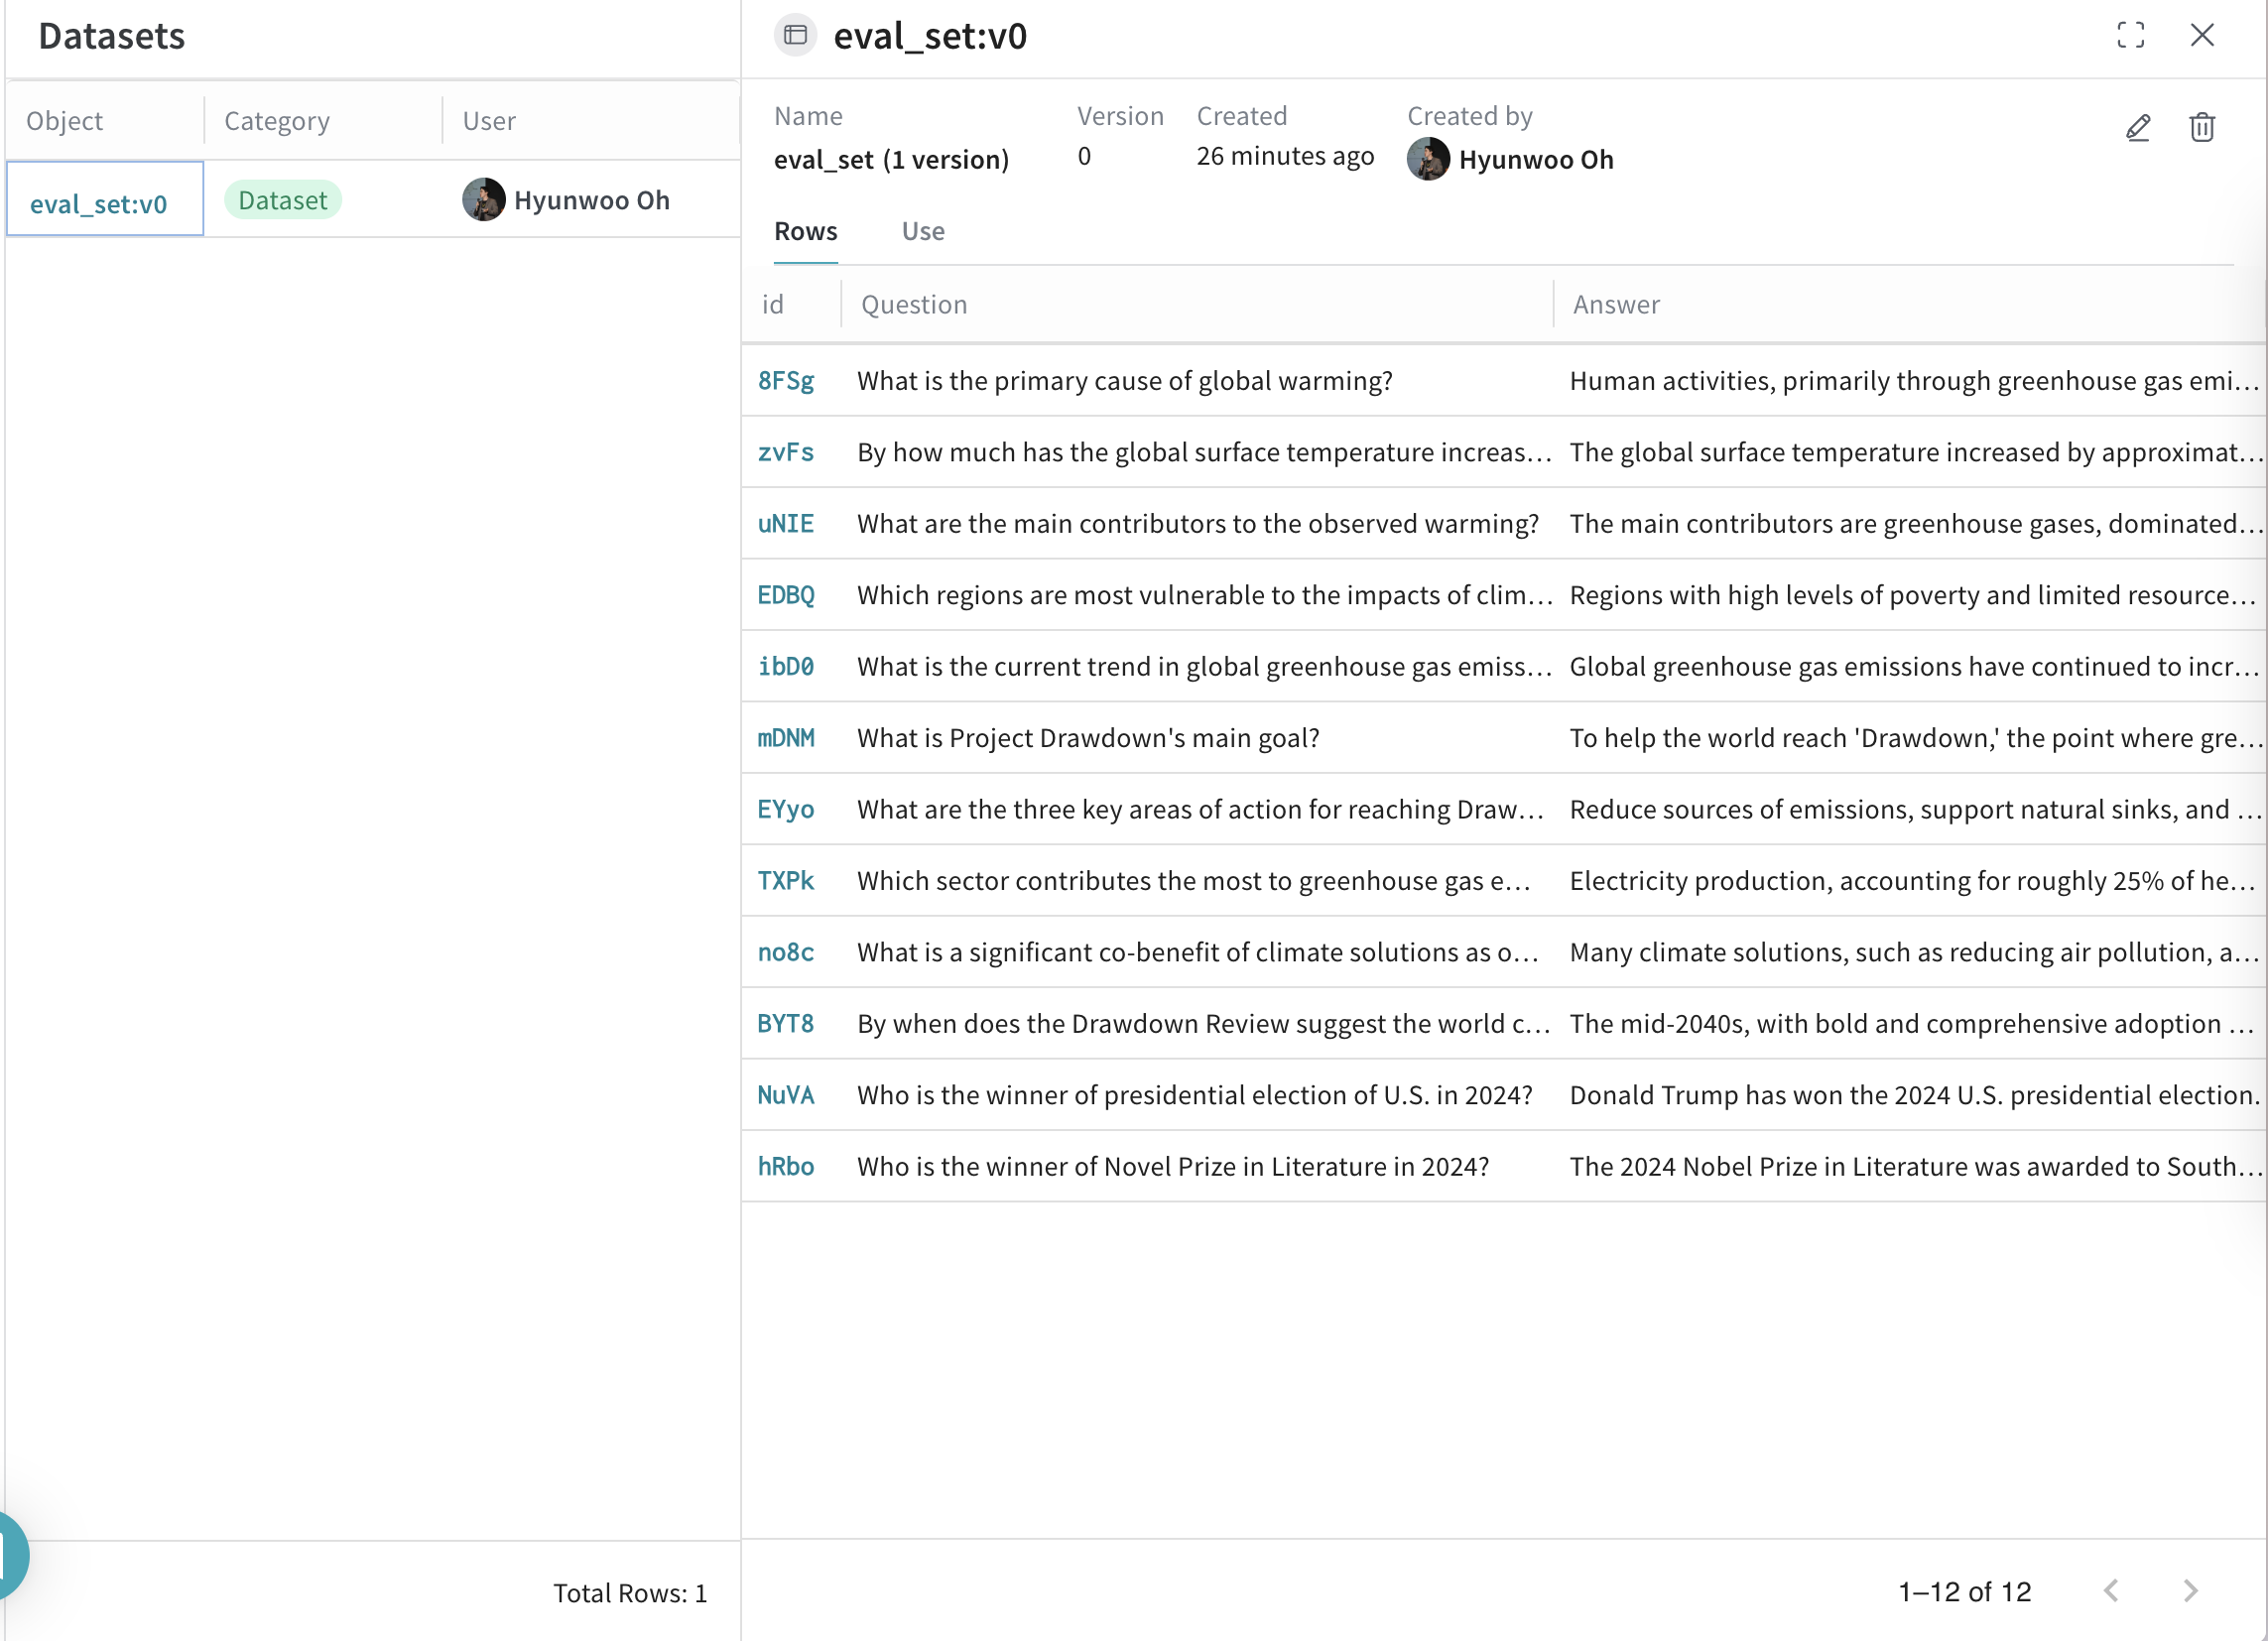

In [ ]:
# 평가 데이터셋 생성
import pandas as pd

data = [["What is the primary cause of global warming?","Human activities, primarily through greenhouse gas emissions, have unequivocally caused global warming."],
["By how much has the global surface temperature increased in the period 2011–2020 compared to 1850–1900?","The global surface temperature increased by approximately 1.1°C compared to 1850–1900."],
["What are the main contributors to the observed warming?","The main contributors are greenhouse gases, dominated by CO2 and methane, partially offset by aerosol cooling."],
["Which regions are most vulnerable to the impacts of climate change?","Regions with high levels of poverty and limited resources, including LDCs, SIDS, and Arctic regions, are among the most vulnerable."],
["What is the current trend in global greenhouse gas emissions?","Global greenhouse gas emissions have continued to increase over the period 2010–2019."],
["What is Project Drawdown's main goal?","To help the world reach 'Drawdown,' the point where greenhouse gas levels in the atmosphere stop rising and begin to decline."],
["What are the three key areas of action for reaching Drawdown?","Reduce sources of emissions, support natural sinks, and improve societal systems for equality."],
["Which sector contributes the most to greenhouse gas emissions according to the Drawdown Review?","Electricity production, accounting for roughly 25% of heat-trapping emissions globally."],
["What is a significant co-benefit of climate solutions as outlined in the Drawdown Review?","Many climate solutions, such as reducing air pollution, also enhance public health and social equity."],
["By when does the Drawdown Review suggest the world could reach Drawdown with ambitious climate action?","The mid-2040s, with bold and comprehensive adoption of existing solutions."],
["Who is the winner of presidential election of U.S. in 2024?","Donald Trump has won the 2024 U.S. presidential election."],
["Who is the winner of Novel Prize in Literature in 2024?","The 2024 Nobel Prize in Literature was awarded to South Korean author Han Kang for her “intense poetic prose that confronts historical traumas and exposes the fragility of human life."]]

df = pd.DataFrame(data, columns=["Question", "Answer"])
dataset = weave.Dataset(name="eval_set", rows=df)
#weave.publish(dataset)

## 평가 함수
LLM as Judge를 이용하여 평가를 진행합니다. 이 때 Weave를 이용하면 LLM의 평가 논리를 이해할 수 있습니다.

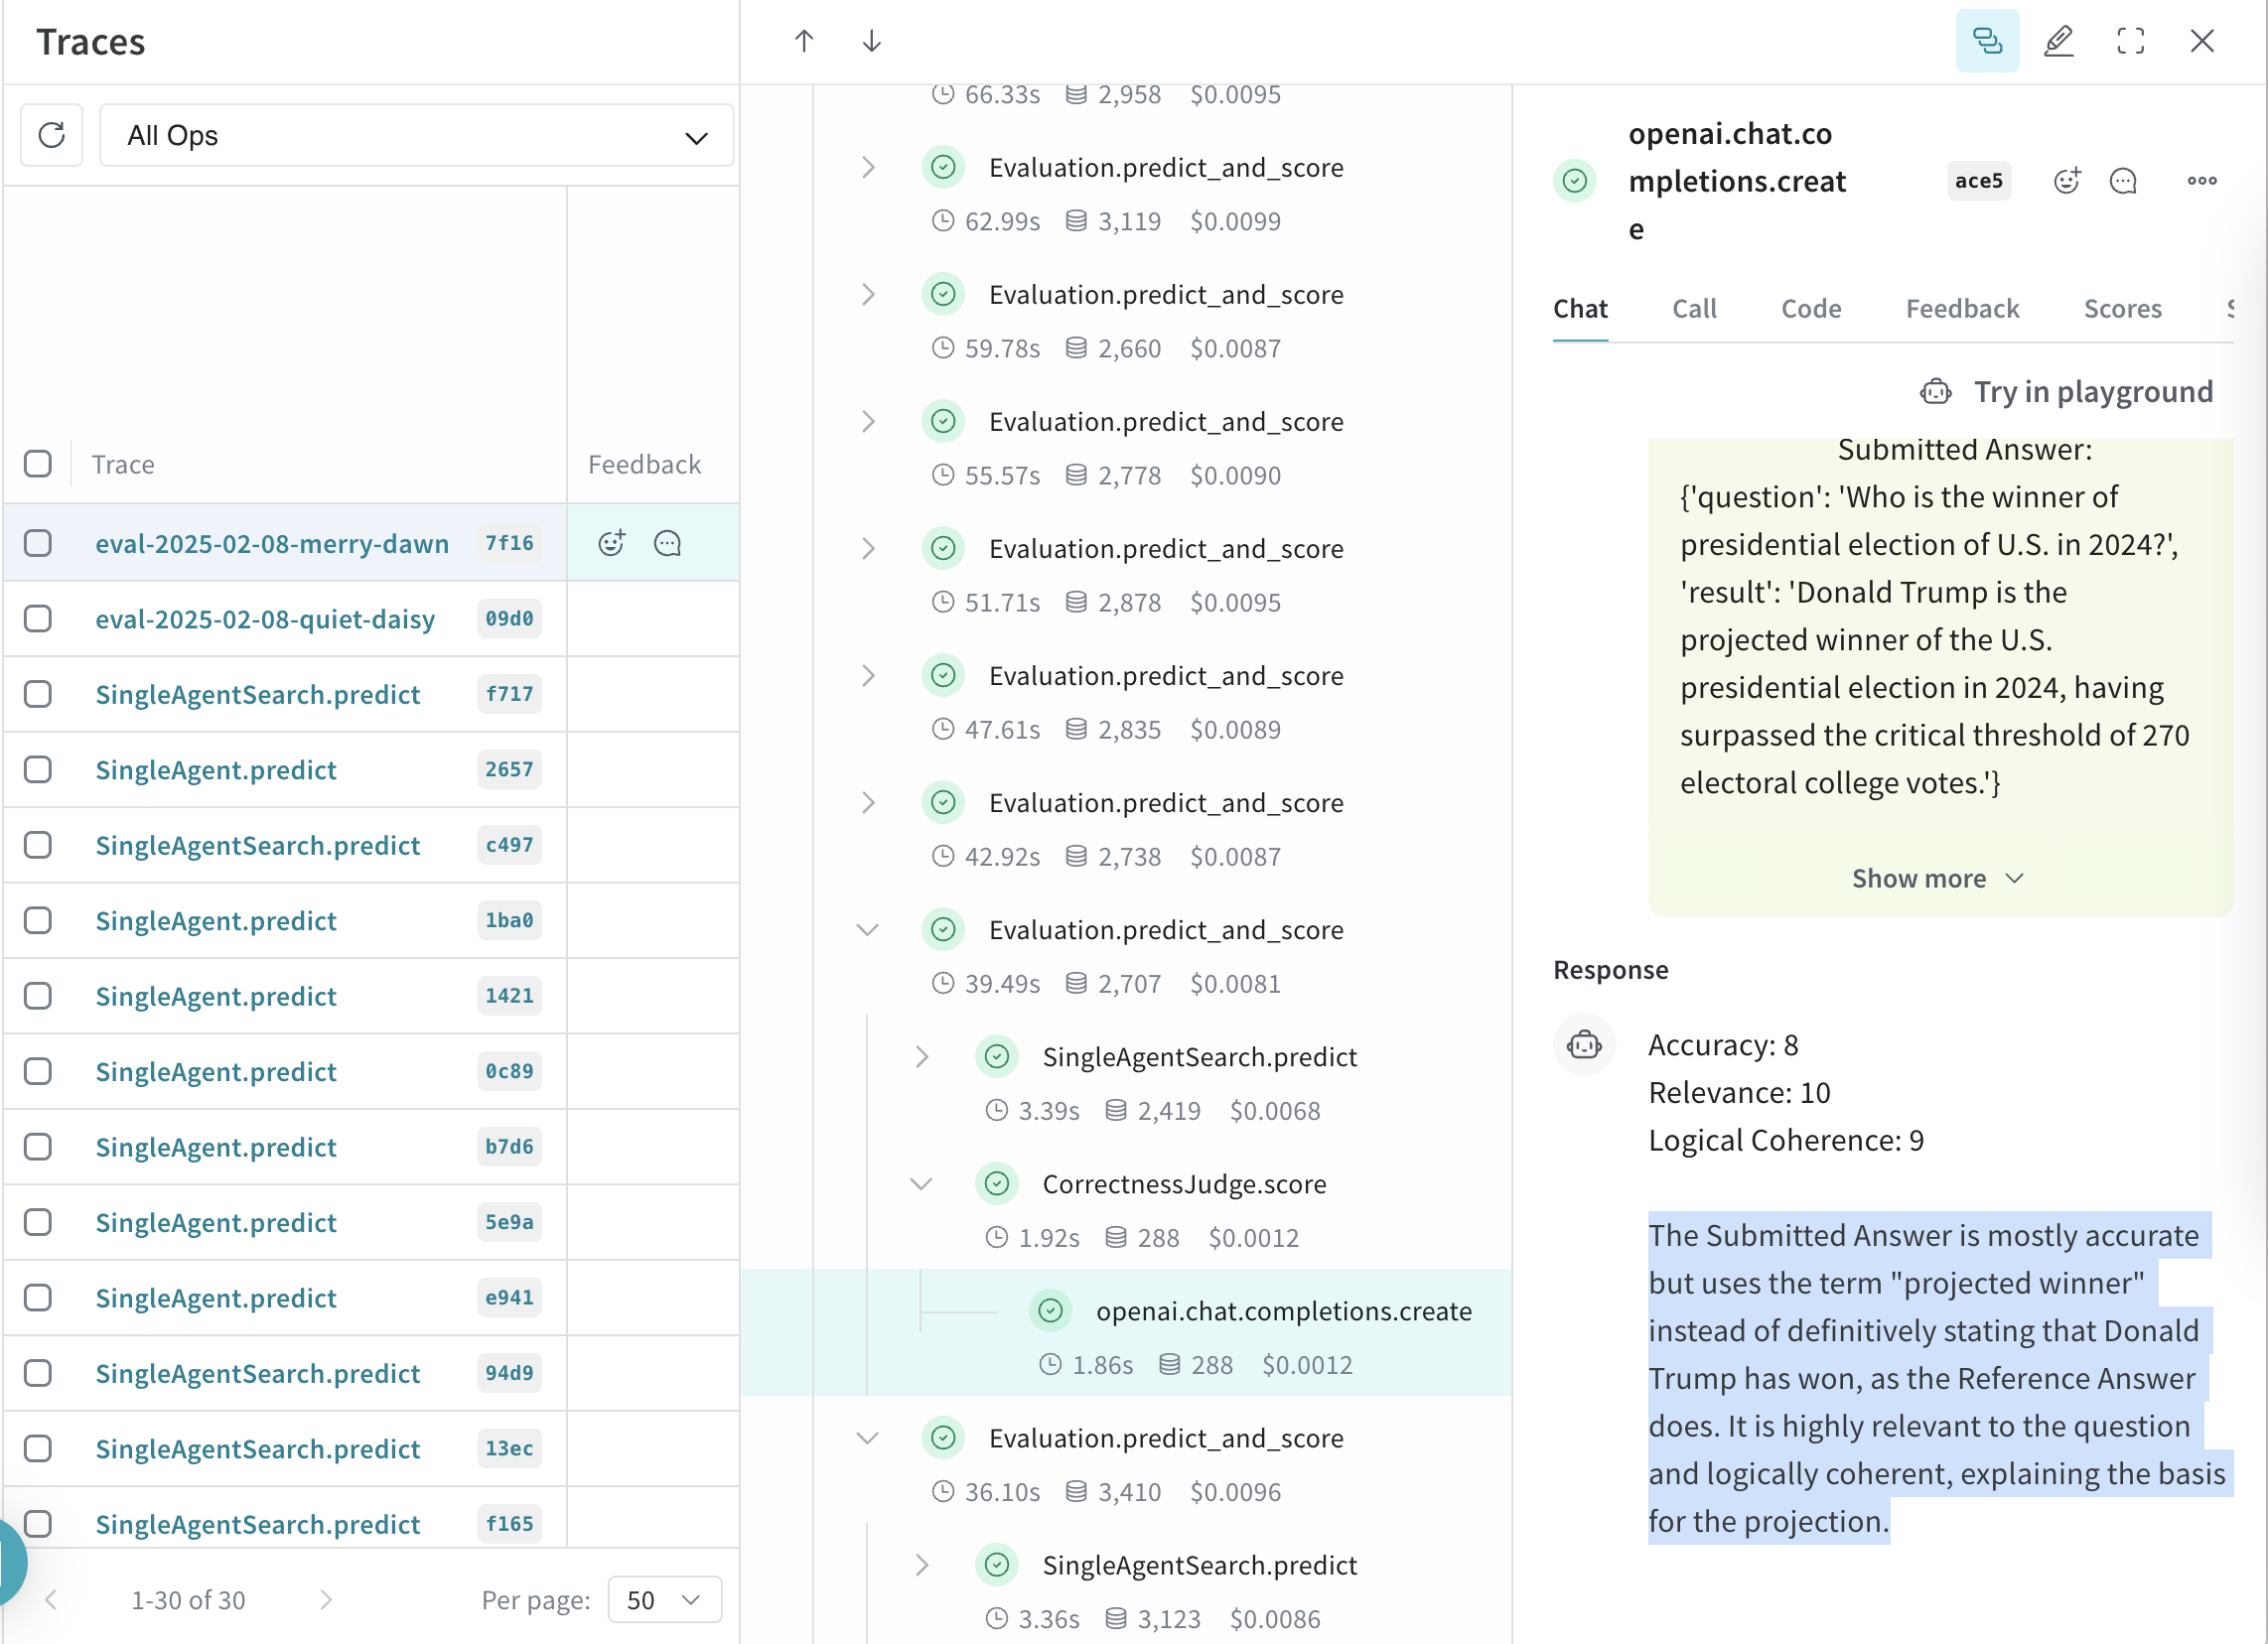

In [ ]:
# 평가함수
import weave
from weave.flow.scorer import Scorer
import openai

class CorrectnessJudge(Scorer):
    @weave.op
    def score(self, Question, model_output, Answer):
        """
        Evaluates an model_output against a reference Answer based on predefined criteria:
        Accuracy, Relevance, and Logical Coherence.

        Args:
            Question (str): The Question posed.
            model_output (str): The Answer to evaluate.
            Answer (str): The reference or correct Answer.

        Returns:
            dict: A dictionary with scores for Accuracy, Relevance, and a Logical Coherence.
        """

        client = openai.Client(
            base_url="https://api.openai.com/v1/"
        )

        response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                            {
                                "role": "system",
                                "content": "You are an expert evaluator for Question-Answer pairs."
                            },
                            {
                                "role": "user",
                                "content": f"""
                        Question: {Question}
                        Reference Answer: {Answer}
                        Submitted Answer: {model_output}

                        Please evaluate the Submitted Answer based on the following criteria:
                        1. Accuracy (0-10): How well does the Answer align with the Reference Answer?
                        2. Relevance (0-10): How relevant is the Answer to the Question?
                        3. Logical Coherence (0-10): How logical and coherent is the Answer?

                        Provide the scores in the format:
                        Accuracy: X
                        Relevance: Y
                        Logical Coherence: Z
                        """
                            }
                        ],
                temperature=0.
            )
        response = response.choices[0].message.content
        try:
            return self._parse_scores(response)
        except Exception as e:
            print(f"Error during evaluation: {e}")
            return {"Accuracy": 0, "Relevance": 0, "Logical Coherence": 0}#, "Final Score": 0}


    def _parse_scores(self, response):
        """
        Parses the model's response to extract scores.

        Args:
            response (str): The raw response from the language model.

        Returns:
            dict: A dictionary of extracted scores.
        """
        scores = {"Accuracy": 0, "Relevance": 0, "Logical Coherence": 0}#, "Final Score": 0}
        try:
            for line in response.split("\n"):
                if "Accuracy" in line:
                    scores["Accuracy"] = int(line.split(":")[1].strip())
                elif "Relevance" in line:
                    scores["Relevance"] = int(line.split(":")[1].strip())
                elif "Logical Coherence" in line:
                    scores["Logical Coherence"] = int(line.split(":")[1].strip())
            # scores["Final Score"] = (
            #     0.5 * scores["Accuracy"] + 0.3 * scores["Relevance"] + 0.2 * scores["Logical Coherence"]
            # )
        except Exception as e:
            print(f"Error parsing scores: {e}")
        return scores

## 평가 실행
Weave 평가 기능을 이용하여 평가를 실행합니다.
아래와 같이 Weave 화면에서 그 결과를 확인할 수 있습니다.

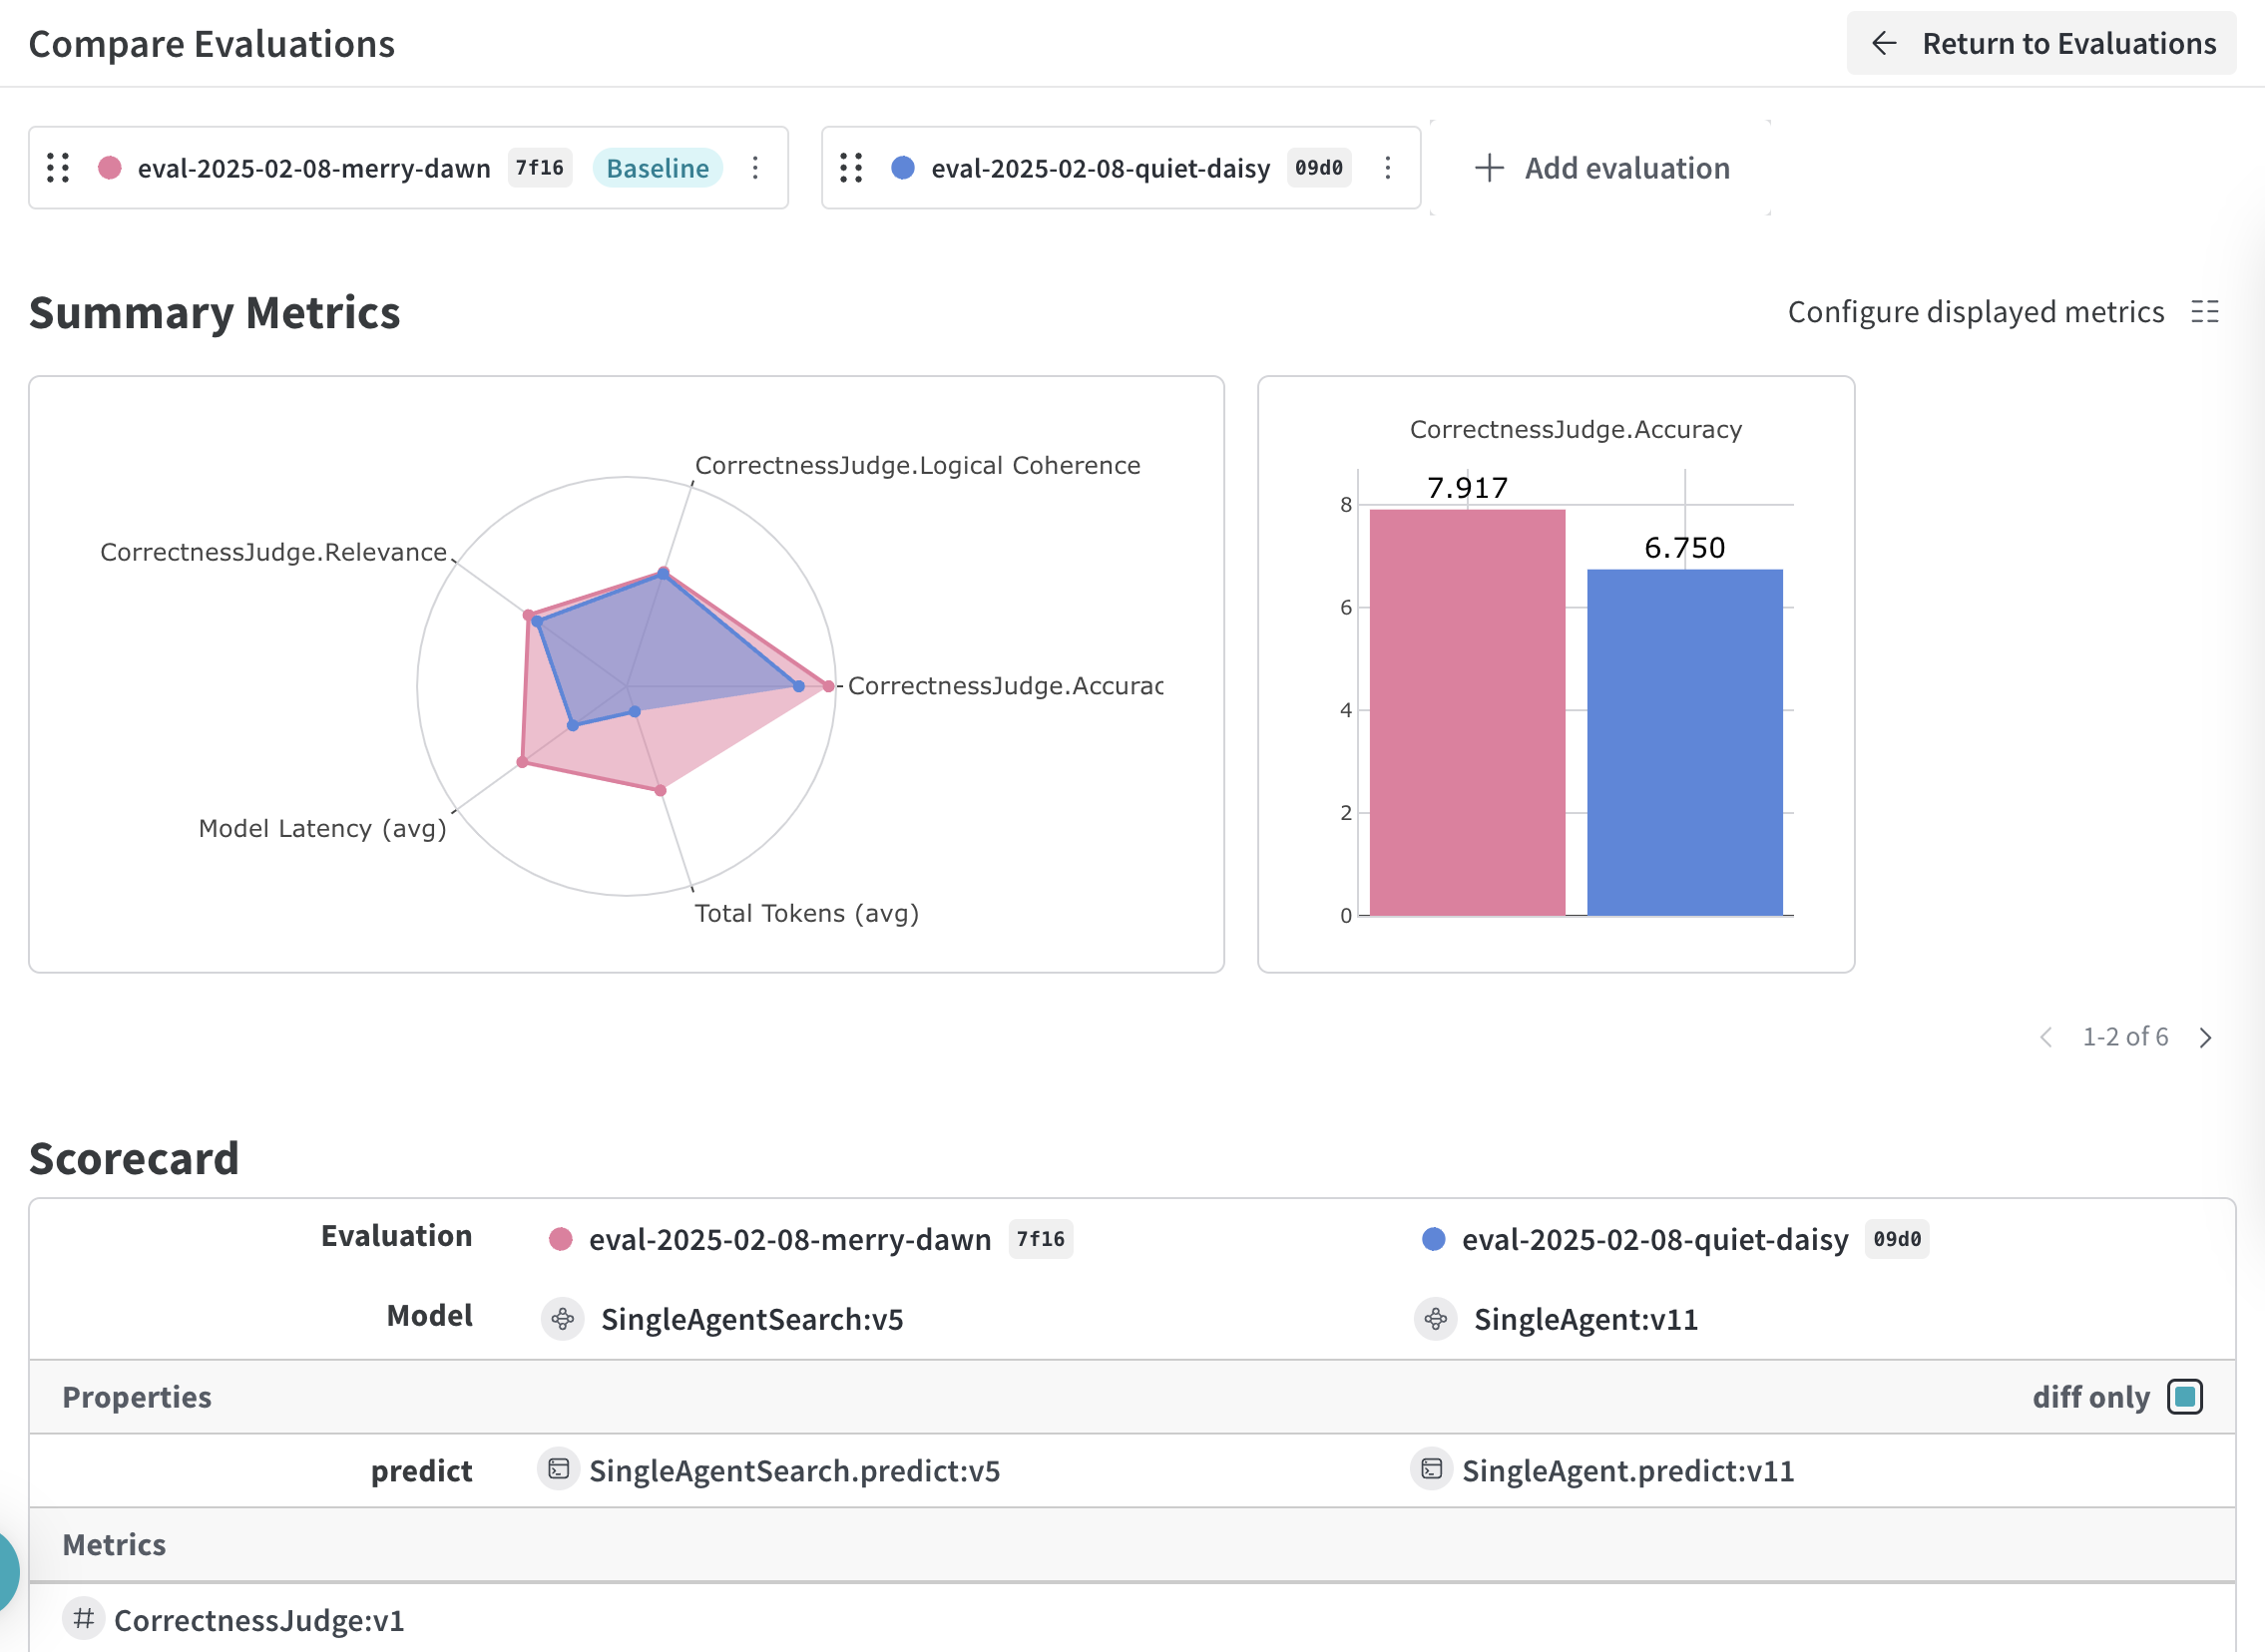


In [ ]:
import asyncio
import nest_asyncio
nest_asyncio.apply()

judge_correctness = CorrectnessJudge()
evaluation = weave.Evaluation(
    dataset = dataset,
    scorers = [judge_correctness]
)

In [ ]:
result = asyncio.run(evaluation.evaluate(agent))

# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the What is the primary cause of global warming?.
        This includes presenting initial thoughts and arguments.
        




# Agent: Expert
## Final Answer: 
The primary cause of global warming is the increase in greenhouse gases, particularly carbon dioxide, methane, and nitrous oxide, due to human activities like burning fossil fuels, deforestation, and industrial processes. These gases trap heat in the atmosphere, leading to rising global temperatures and climate change.


# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the By how much has the global surface temperature increased in the period 2011–2020 compared to 1850–1900?.
        This includes presenting initial thoughts and arguments.
        




# Agent: Expert
## Final Answer: 
The global surface temperature increased by approximately 1.1°C in the period 2011–2020 compared to the baseline period of 1850–1900. This rise is indicative of significant human-driven climate change, emphasizing the urgent need for mitigation strategies to address greenhouse gas emissions and global warming.


# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the What are the main contributors to the observed warming?.
        This includes presenting initial thoughts and arguments.
        




# Agent: Expert
## Final Answer: 
Human activities, especially the burning of fossil fuels (coal, oil, and gas), deforestation, and industrial processes, are the main contributors to observed warming. These activities increase greenhouse gases like CO2 and methane, trapping heat in the atmosphere and leading to climate change. Natural factors play a minimal role compared to human influence.


# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the Which regions are most vulnerable to the impacts of climate change?.
        This includes presenting initial thoughts and arguments.
        




# Agent: Expert
## Final Answer: 
Regions most vulnerable to climate change include small island nations, low-lying coastal areas like Bangladesh, arid regions such as the Sahel in Africa, and Arctic regions. These areas face rising sea levels, extreme weather events, drought, and habitat loss, impacting livelihoods, ecosystems, and security.


# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the What is the current trend in global greenhouse gas emissions?.
        This includes presenting initial thoughts and arguments.
        




# Agent: Expert
## Final Answer: 
As of 2023, global greenhouse gas emissions are showing a concerning trend of fluctuating rather than declining consistently despite international climate agreements. This plateau reflects challenges in transitioning from fossil fuels, with a need for accelerated renewable energy adoption and policies to curb emissions effectively for sustained impact.


# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the What is Project Drawdown's main goal?.
        This includes presenting initial thoughts and arguments.
        




# Agent: Expert
## Final Answer: 
Project Drawdown's main goal is to identify and promote practical solutions to reverse global warming. It focuses on quantifying and scaling up solutions that reduce greenhouse gases in the atmosphere, prioritizing renewable energy, sustainable agriculture, and efficient technologies. Its aim is to reach 'drawdown,' the point where atmospheric carbon levels decline.


# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the What are the three key areas of action for reaching Drawdown?.
        This includes presenting initial thoughts and arguments.
        




# Agent: Expert
## Final Answer: 
The three key areas of action for reaching Drawdown are reducing sources, supporting sinks, and improving society. Reducing sources involves cutting greenhouse gas emissions from sectors like energy and transportation. Supporting sinks means enhancing natural and technological systems that remove carbon dioxide, while improving society focuses on actions like promoting equity and education.


# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the Which sector contributes the most to greenhouse gas emissions according to the Drawdown Review?.
        This includes presenting initial thoughts and arguments.
        




# Agent: Expert
## Final Answer: 
According to the Drawdown Review, the electricity generation sector contributes the most to greenhouse gas emissions. This is primarily due to the high reliance on fossil fuels such as coal, oil, and natural gas for power generation, which release significant amounts of carbon dioxide and other greenhouse gases into the atmosphere.


# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the What is a significant co-benefit of climate solutions as outlined in the Drawdown Review?.
        This includes presenting initial thoughts and arguments.
        




# Agent: Expert
## Final Answer: 
One significant co-benefit of climate solutions, as highlighted in the Drawdown Review, is the improvement of public health. By reducing emissions, enhancing air quality, and promoting sustainable agriculture, these solutions help decrease respiratory illnesses, improve food security, and increase overall health and well-being.


# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the By when does the Drawdown Review suggest the world could reach Drawdown with ambitious climate action?.
        This includes presenting initial thoughts and arguments.
        




# Agent: Expert
## Final Answer: 
The Drawdown Review suggests that with ambitious climate action, the world could reach Drawdown — the point where greenhouse gases peak and begin to decline — by the mid-century, around 2040-2050. Achieving this requires significant investment in renewable energy, improved energy efficiency, and sustainable land use practices.


# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the Who is the winner of presidential election of U.S. in 2024?.
        This includes presenting initial thoughts and arguments.
        




# Agent: Expert
## Final Answer: 
As of now, the winner of the 2024 U.S. presidential election is not known. The election results will be determined after the official voting occurs and all votes are counted. Stay informed with reliable news sources for the most accurate and up-to-date information.


# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the Who is the winner of Novel Prize in Literature in 2024?.
        This includes presenting initial thoughts and arguments.
        


# Agent: Expert
## Final Answer: 
As of now, it's October 2023, and the winner of the Nobel Prize in Literature for 2024 has not been announced yet. The Nobel Prize in Literature typically announces its winners in early October each year, following which updates will be available.




Evaluated 1 of 12 examples

Evaluated 2 of 12 examples

Evaluated 3 of 12 examples

Evaluated 4 of 12 examples

Evaluated 5 of 12 examples

Evaluated 6 of 12 examples

Evaluated 7 of 12 examples

Evaluated 8 of 12 examples

Evaluated 9 of 12 examples

Evaluated 10 of 12 examples

Evaluated 11 of 12 examples

Evaluated 12 of 12 examples

Evaluation summary
{
    'CorrectnessJudge': {
        'Accuracy': {'mean': 6.916666666666667},
        'Logical Coherence': {'mean': 9.166666666666666},
        'Relevance': {'mean': 8.916666666666666}
    },
    'model_latency': {'mean': 56.123465259869896}
}

🍩 https://wandb.ai/rocodoco20-colaborandonet/ai-agent-search-example/r/call/0194f57a-fde1-7711-8c46-49ad60126c49


In [ ]:
result = asyncio.run(evaluation.evaluate(agent_search))

# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the What is the primary cause of global warming?.
        This includes presenting initial thoughts and arguments.
        


# Agent: Expert
## Thought: Thought: To provide insights on the primary cause of global warming, an understanding of the scientific consensus and recent research on the topic is crucial. I will search for the latest information to ensure accurate and up-to-date insights.
## Using tool: Search the internet with Serper
## Tool Input: 
"{\"search_query\": \"primary cause of global warming 2023\"}"
## Tool Output: 
{'searchParameters': {'q': 'primary cause of global warming 2023', 'type': 'search', 'num': 10, 'engine': 'google'}, 'organic': [{'title': 'Climate change indicators reached record levels in 2023: WMO', 'link': 'https://wmo.int/news/media-centre/climate-change-indicators-reached-record-levels-2023-wmo', 'snippet': 'The long-term increase in global temperature



# Agent: Expert
## Final Answer: 
The primary cause of global warming is the increased concentration of greenhouse gases, particularly carbon dioxide, due to human activities like burning fossil fuels, deforestation, and industrial processes. These emissions trap heat in the atmosphere, significantly contributing to the Earth's rising temperatures.


# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the By how much has the global surface temperature increased in the period 2011–2020 compared to 1850–1900?.
        This includes presenting initial thoughts and arguments.
        


# Agent: Expert
## Thought: Thought: To provide accurate insights on the increase in global surface temperature from 1850–1900 to 2011–2020, current and reliable scientific data is required. I will search for recent studies or reports on this topic to ensure information is up-to-date.
## Using tool: Search the internet with Serper
## Tool Input: 
"{\"search_qu



# Agent: Expert
## Final Answer: 
The global surface temperature increased by approximately 1.1°C from the baseline period of 1850–1900 to 2011–2020. This rise is primarily attributed to human-induced climate change, with implications for ecosystems, weather patterns, and sea levels worldwide.


# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the What are the main contributors to the observed warming?.
        This includes presenting initial thoughts and arguments.
        


# Agent: Expert
## Thought: Thought: The main contributors to observed warming are critical for understanding climate change. I will search for the most recent scientific insights on this topic to provide an informed and accurate analysis.
## Using tool: Search the internet with Serper
## Tool Input: 
"{\"search_query\": \"main contributors to observed global warming 2023\"}"
## Tool Output: 
{'searchParameters': {'q': 'main contributors to observed global warmi



# Agent: Expert
## Final Answer: 
The main contributors to observed warming are human activities, primarily the burning of fossil fuels, deforestation, and industrial processes, leading to increased greenhouse gas emissions. These activities cause higher concentrations of CO2 and other greenhouse gases, driving global temperature rise. Natural factors like El Niño also play a role.


# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the Which regions are most vulnerable to the impacts of climate change?.
        This includes presenting initial thoughts and arguments.
        


# Agent: Expert
## Thought: Thought: To provide informed insights on which regions are most vulnerable to the impacts of climate change, I should consider current research and expert analysis on climatic vulnerability. I will search for the latest data and studies on this topic to support my answer.
## Using tool: Search the internet with Serper
## Tool Input: 




# Agent: Expert
## Final Answer: 
Regions most vulnerable to climate change include African nations like Chad, Somalia, and Democratic Republic of Congo; Middle Eastern countries like Syria; South Asian countries such as Afghanistan; and parts of Central America. Factors like poverty, political instability, and geographic location contribute to their vulnerability.


# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the What is the current trend in global greenhouse gas emissions?.
        This includes presenting initial thoughts and arguments.
        


# Agent: Expert
## Thought: Thought: To provide insights and arguments on the current trend in global greenhouse gas emissions, I need to search for the most recent and reliable data and analyses on this topic.
## Using tool: Search the internet with Serper
## Tool Input: 
"{\"search_query\": \"current trend in global greenhouse gas emissions 2023\"}"
## Tool Output: 
{'searchParamete



# Agent: Expert
## Final Answer: 
In 2023, global greenhouse gas emissions continue to rise, reaching new record levels. Despite efforts in clean energy, emissions increased by around 1.1% over the previous year. Carbon dioxide, methane, and nitrous oxide levels maintain a steady climb, driven predominantly by fossil fuel use.
```


# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the What is Project Drawdown's main goal?.
        This includes presenting initial thoughts and arguments.
        


# Agent: Expert
## Using tool: Search the internet with Serper
## Tool Input: 
"{\"search_query\": \"Project Drawdown main goal\"}"
## Tool Output: 
{'searchParameters': {'q': 'Project Drawdown main goal', 'type': 'search', 'num': 10, 'engine': 'google'}, 'organic': [{'title': 'Project Drawdown: Home', 'link': 'https://drawdown.org/', 'snippet': "Project Drawdown's programs are working to advance climate solutions—such as plant-rich diets—acr



# Agent: Expert
## Final Answer: 
Project Drawdown's main goal is to achieve "drawdown," the point where levels of greenhouse gases in the atmosphere stop climbing and begin to steadily decline. It seeks to reverse global warming through comprehensive, scientific-based solutions, effectively reducing greenhouse gas concentrations and promoting equitable climate action.
```


# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the What are the three key areas of action for reaching Drawdown?.
        This includes presenting initial thoughts and arguments.
        


# Agent: Expert
## Thought: Thought: To provide insights on the three key areas of action for reaching Drawdown, I need to confirm current understanding and findings on Project Drawdown's framework and strategies.
## Using tool: Search the internet with Serper
## Tool Input: 
"{\"search_query\": \"three key areas of action for reaching Drawdown Project Drawdown\"}"
## Tool Out



# Agent: Expert
## Final Answer: 
The three key areas of action for reaching Drawdown are: 1) Reduce sources—minimizing the human causes of emissions, 2) Support sinks—enhancing natural systems that remove and store carbon, and 3) Improve society—fostering equality to ensure broad participation and equitable climate solutions deployment.
```


# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the Which sector contributes the most to greenhouse gas emissions according to the Drawdown Review?.
        This includes presenting initial thoughts and arguments.
        


# Agent: Expert
## Thought: Thought: To provide insights on which sector contributes the most to greenhouse gas emissions according to the Drawdown Review, I need to find the specific data or analysis from the Drawdown Review on the distribution of emissions across sectors.
## Using tool: Search the internet with Serper
## Tool Input: 
"{\"search_query\": \"Drawdown Review s



# Agent: Expert
## Final Answer: 
The Drawdown Review identifies the food, agriculture, and land use sector as a major contributor to greenhouse gas emissions, accounting for 22-33% of total emissions, highlighting its significant impact on climate change.


# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the What is a significant co-benefit of climate solutions as outlined in the Drawdown Review?.
        This includes presenting initial thoughts and arguments.
        


# Agent: Expert
## Thought: Thought: To provide the most accurate insights and arguments regarding the significant co-benefit of climate solutions as outlined in the Drawdown Review, I need to search for the specific details mentioned in the document.
## Using tool: Search the internet with Serper
## Tool Input: 
"{\"search_query\": \"significant co-benefit of climate solutions Drawdown Review\"}"
## Tool Output: 
{'searchParameters': {'q': 'significant co-benefit o



# Agent: Expert
## Final Answer: 
A significant co-benefit of climate solutions as outlined by the Drawdown Review is the advancement of social and economic equity. Climate solutions can improve human health, enhance food security, protect biodiversity, and create jobs, all contributing to a more equitable world.
```


# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the By when does the Drawdown Review suggest the world could reach Drawdown with ambitious climate action?.
        This includes presenting initial thoughts and arguments.
        


# Agent: Expert
## Thought: Thought: To provide an accurate answer, I need to find the most current details regarding the timeline suggested by the Drawdown Review for reaching Drawdown with ambitious climate action. I will perform a search to gather relevant information.
## Using tool: Search the internet with Serper
## Tool Input: 
"{\"search_query\": \"Drawdown Review 2023 timeline for rea



# Agent: Expert
## Final Answer: 
The Drawdown Review suggests that with purpose and determination in climate solutions, the world could reach Drawdown as early as the mid-2040s, or potentially not until the 2060s.


# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the Who is the winner of presidential election of U.S. in 2024?.
        This includes presenting initial thoughts and arguments.
        


# Agent: Expert
## Using tool: Search the internet with Serper
## Tool Input: 
"{\"search_query\": \"2024 U.S. presidential election winner\"}"
## Tool Output: 
{'searchParameters': {'q': '2024 U.S. presidential election winner', 'type': 'search', 'num': 10, 'engine': 'google'}, 'organic': [{'title': 'Presidential election results 2024 | CNN Politics', 'link': 'https://www.cnn.com/election/2024/results/president', 'snippet': 'View maps and real-time results for the 2024 US presidential election matchup between former President Donald Tr



# Agent: Expert
## Final Answer: 
Donald Trump won the 2024 U.S. presidential election, surpassing the critical threshold of 270 electoral college votes. He faced off against Kamala Harris in this election cycle.
```


# Agent: Expert
## Task: 
        Expert provides insights based on the knowledge of expertise on the Who is the winner of Novel Prize in Literature in 2024?.
        This includes presenting initial thoughts and arguments.
        


# Agent: Expert
## Thought: Thought: I need to find out who the winner of the Nobel Prize in Literature for 2024 is. To do so, I will search for recent news or announcements on the topic.
## Using tool: Search the internet with Serper
## Tool Input: 
"{\"search_query\": \"Nobel Prize in Literature 2024 winner\"}"
## Tool Output: 
{'searchParameters': {'q': 'Nobel Prize in Literature 2024 winner', 'type': 'search', 'num': 10, 'engine': 'google'}, 'knowledgeGraph': {'title': 'Han Kang', 'type': 'South Korean writer', 'website': 'https://en.

Evaluated 1 of 12 examples

Evaluated 2 of 12 examples

Evaluated 3 of 12 examples

Evaluated 4 of 12 examples

Evaluated 5 of 12 examples

Evaluated 6 of 12 examples

Evaluated 7 of 12 examples

Evaluated 8 of 12 examples

Evaluated 9 of 12 examples

Evaluated 10 of 12 examples

Evaluated 11 of 12 examples

Evaluated 12 of 12 examples

Evaluation summary
{
    'CorrectnessJudge': {
        'Accuracy': {'mean': 8.0},
        'Logical Coherence': {'mean': 9.333333333333334},
        'Relevance': {'mean': 9.25}
    },
    'model_latency': {'mean': 61.70388718446096}
}

🍩 https://wandb.ai/rocodoco20-colaborandonet/ai-agent-search-example/r/call/0194f57c-8b83-7750-96f5-290c0362e2e5


## [MY CODE]
facebook/opt-350m 모델과 lucasmccabe-lmi/CodeAlpaca-20k 데이터셋을 활용
SFTTrainer를 사용하며 max_seq_length=128 설정
wandb를 이용해 loss 및 학습 속도를 로깅
torch.cuda.memory_allocated()를 활용하여 메모리 점유율 출력

In [ ]:
!pip uninstall -y transformers tokenizers
!pip install -U transformers tokenizers

Found existing installation: transformers 4.48.3
Uninstalling transformers-4.48.3:
  Successfully uninstalled transformers-4.48.3
Found existing installation: tokenizers 0.21.0
Uninstalling tokenizers-0.21.0:
  Successfully uninstalled tokenizers-0.21.0
  Using cached transformers-4.48.3-py3-none-any.whl.metadata (44 kB)
  Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached transformers-4.48.3-py3-none-any.whl (9.7 MB)
Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chromadb 0.5.23 requires tokenizers<=0.20.3,>=0.13.2, but you have tokenizers 0.21.0 which is incompatible.


In [ ]:
!pip install -U trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.9/313.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from huggingface_hub import list_datasets

datasets_list = list_datasets()
print([d.id for d in datasets_list if "codealpaca" in d.id.lower()])

['theblackcat102/evol-codealpaca-v1', 'AlekseyKorshuk/evol-codealpaca-v1-dpo', 'pszemraj/fleece2instructions-codealpaca', 'sahil2801/CodeAlpaca-20k', 'HuggingFaceH4/CodeAlpaca_20K', 'HuggingFaceH4/testing_codealpaca_small', 'thisisanshgupta/CodeAlpaca', 'thisisanshgupta/CodeAlpacaSmall', 'Abzu/CodeAlpacaPython', 'HydraLM/CodeAlpaca-20k_standardized', 'HydraLM/CodeAlpaca-20k_list_dict', 'HydraLM/CodeAlpaca-20k_alpaca', 'open-llm-leaderboard-old/details_jordiclive__gpt4all-alpaca-oa-codealpaca-lora-13b', 'vikp/evol_codealpaca_filtered_87k', 'YoungPhlo/juyongjiang-codeup_master_data_new_codealpaca_standardized', 'khalidalt/evol-codealpaca-v1-standardized', 'antolin/codealpaca-filtered', 'PsiPi/CodeAlpaca_20k_NoBlanks', 'alpayariyak/evol-codealpaca-decontaminated', 'jan-hq/evol_codealpaca_binarized', 'open-llm-leaderboard-old/details_HenryJJ__Instruct_Yi-6B_Dolly_CodeAlpaca', 'obrmmk/JCodeAlpaca-py-8k', 'AlekseyKorshuk/evol-codealpaca-seed', 'AlekseyKorshuk/evol-codealpaca-pairwise', 'Alek

In [ ]:
import torch
import wandb
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import get_peft_model, LoraConfig, TaskType
from trl import SFTTrainer, SFTConfig
from datasets import load_dataset
import time

# LoRA 설정값
LORA_RANKS = [8, 128, 256]
MODEL_NAME = "facebook/opt-350m"
DATASET_NAME = "HydraLM/CodeAlpaca-20k_standardized"
OUTPUT_DIR = "./lora_results"

# WandB 초기화
wandb.init(project="lora_rank_experiment", name="lora_experiment")

def train_lora(rank):
    print(f"Training with LoRA Rank: {rank}")

    # 모델 및 토크나이저 불러오기
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    dataset = load_dataset(DATASET_NAME, split="train")

    dataset = dataset.select(range(len(dataset) // 10))

    # 데이터셋 필드 확인
    print(f"Dataset columns: {dataset.column_names}")

    # 'message' 컬럼을 텍스트로 사용
    dataset = dataset.map(lambda x: tokenizer(x['message'], padding=True, truncation=True, max_length=128))

    # LoRA 설정
    lora_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        r=rank,
        lora_alpha=16,
        lora_dropout=0.05,
        bias="none"
    )
    model = get_peft_model(model, lora_config)

    # 학습 설정
    trainer = SFTTrainer(
        model,
        train_dataset=dataset,
        args=SFTConfig(
            output_dir=f"{OUTPUT_DIR}/rank_{rank}",
            per_device_train_batch_size=4,
            num_train_epochs=3,
            save_steps=100,
            logging_steps=50,
            learning_rate=5e-5,
            warmup_ratio=0.1,
            max_seq_length=128
        ),
    )

    # 메모리 사용량 체크
    torch.cuda.empty_cache()
    start_mem = torch.cuda.memory_allocated() / (1024 ** 3)  # GB 단위
    start_time = time.time()

    # 학습 수행
    trainer.train()

    # 학습 종료 후 메모리 및 시간 측정
    end_mem = torch.cuda.memory_allocated() / (1024 ** 3)
    end_time = time.time()
    train_time = end_time - start_time

    print(f"Rank {rank} - Training Time: {train_time:.2f} sec, Memory Used: {end_mem - start_mem:.2f} GB")

    # WandB 로그 기록
    wandb.log({
        "LoRA Rank": rank,
        "Training Time (s)": train_time,
        "Memory Usage (GB)": end_mem - start_mem
    })

# 각 LoRA Rank에 대해 학습 실행
for rank in LORA_RANKS:
    train_lora(rank)

wandb.finish()


Training with LoRA Rank: 8
Dataset columns: ['message', 'message_type', 'message_id', 'conversation_id']


Map:   0%|          | 0/6006 [00:00<?, ? examples/s]

Rank 8 - Training Time: 670.79 sec, Memory Used: 0.01 GB
Training with LoRA Rank: 128
Dataset columns: ['message', 'message_type', 'message_id', 'conversation_id']


Rank 128 - Training Time: 704.55 sec, Memory Used: 0.09 GB
Training with LoRA Rank: 256
Dataset columns: ['message', 'message_type', 'message_id', 'conversation_id']


Rank 256 - Training Time: 852.44 sec, Memory Used: 0.19 GB
